# Personal Financial Planning

In [1]:
import numpy as np
import pandas as pd
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML

# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

## References

<https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.financial.html>  
<http://pbpython.com/amortization-model-revised.html>  
<http://www.financialmodellinghandbook.com/2014/03/15/sign-conventions/>  
<https://cleffinance.blogspot.com/2012/01/pv-pmt-when-to-put-negative.html>  


<https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/>  
<http://inmachineswetrust.com/posts/understanding-generators/#cell3>  
<https://github.com/NelisW/PythonNotesToSelf/blob/master/Generators.ipynb>




## Introduction

This notebook is a collection of calculations attempting to understand the positive (growth) and negative elements (cost and risk) in investments. It is not even considering dealing on the equity markets, but rather investigating small, longer-term, personal investments.

**A note on dates:**  The default start date in this notebook is 2000-01-01, mainly because it is easy to calculate the term remaining from a round number.  The date 0000-01-01 is not allowed in the Python code, so I start with the year 2000.

Terminology: 

A *mortgage* is a loan (usually secured by a bond) where the purpose of the loan is to purchase a fixed asset in the name of the borrower, but where the lender has the right to seize the asset if the borrower defaults on payment. The lender's right to seize falls away once the loan is fully repaid.

A *bond* is is a long term load agreement (by contract or certificate) whereby one party undertakes to repay the principal amount of the loan with interest by an agreed date. The term 'bond' is used in this document to imply a bond with a schedule of regular payments, usually monthly. In this notebook the terms bond and mortgage are use mostly equivalently.


## Simple Financial Calculations

The sign of a financial value is often confusing: some are positive others are negative. 

* When money is taken out from your pocket (outflows, you pay): use a negative sign.  
* When money is given to you (inflows, pay to you), use a positive sign.

When you borrow money, the capital principal is flowing in, it must be positice. The interest and payment due is flowing out, it must be negative.

When you withdraw from an investment, the capital flowed out when making the investment, hence it must be negative.
The withdrawal is flowing in, it must be positive.

In [2]:
Interest_Rate = 0.09
BondYears = 20
numAnnPayments = 12
Principal = 1000000
start_date = (date(2000,1,1))

How large a monthly payment is required to repay bond?

In [3]:
pmt = np.pmt(Interest_Rate/numAnnPayments, BondYears*numAnnPayments, Principal)
print(f'Payment required {pmt}')

Payment required -8997.259558501702


How much interest or capital is paid in a specific period (a month in this case)

In [4]:
# Period/month for which to calculate
per = 240

# Calculate the interest
ipmt = np.ipmt(Interest_Rate/numAnnPayments, per, BondYears*numAnnPayments, Principal)

# Calculate the principal
ppmt = np.ppmt(Interest_Rate/numAnnPayments, per, BondYears*numAnnPayments, Principal)

print(f'Interest payment {ipmt}, capital repayment {ppmt}')


Interest payment -66.97711830150335, capital repayment -8930.282440200199


How large should the payment be to pay back a bond with regular payments?

In [5]:
np.pmt(rate=0.09/12, nper=5*12, pv=1000000, fv=0, when='end')

-20758.355226353873

## Time Value of Money

Inflation erodes the buying power of money over time.  As long as your salary keeps track, or exceeds, of inflation, the erosion effect might not be very noticeable. However, if your salary increases slower than inflation, your buying power decreases with time.

From the table below it is evident that the value of money halves in 11.5 years if the inflation rate is 6%.

In [6]:
df = pd.DataFrame()
df['Inflation %'] =  np.linspace(3,15,13)
df['Years-to-half'] = -np.log(0.5)/np.log(1+df['Inflation %']/(100*12))/12
df

,Inflation %,Years-to-half
0,3.0,23.13378
1,4.0,17.35754
2,5.0,13.89180
3,6.0,11.58131
4,7.0,9.93096
5,8.0,8.69319
6,9.0,7.73048
7,10.0,6.96031
8,11.0,6.33018
9,12.0,5.80506


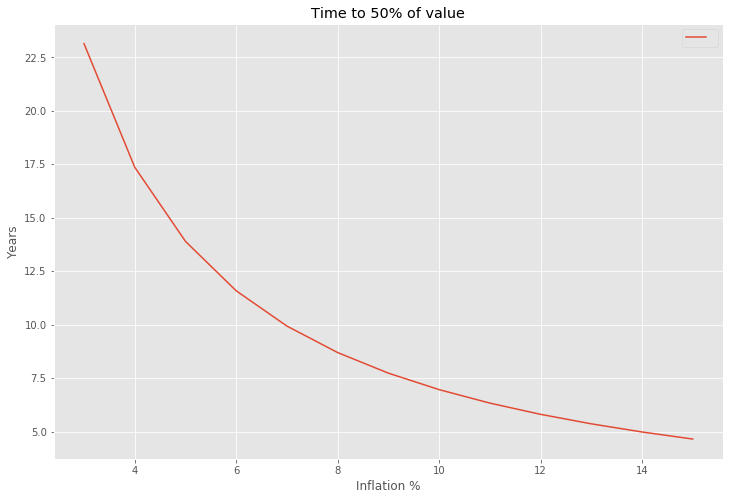

In [7]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
df.plot(x='Inflation %', y='Years-to-half', label=f'', ax=ax)
plt.title("Time to 50% of value");
plt.ylabel("Years");

Suppose it is possible to freeze the time value of money, to always remain at unity.  With the time value of money frozen, we can evaluate the value of asset growth and costs in a manner decoupled from the erosion effect of inflation: we evaluate the investment or cost in terms of  true buying power.  The money value would always have constant buying power irrespective of time into the future.

Freezing the time value of money is readily done by considering any costs or growth relative to the inflation rate. If the inflation rate is 6% and an investment realises 8% growth, the real growth (corrected for inflation) is 2%.  Hence the effect of inflation on time value of money can be removed by considering all costs and growth relative to inflation: just subtract inflation rate.


## Mortgage Bond Amortisation Model

This model and code is taken from http://pbpython.com/amortization-model-revised.html. Moffit was looking for a way to do amortisation  calculations in Pandas without loops, but ended up using a generator function to do the looping.  The generator does a complete set of loops and then provides the answer to a Pandas DataFrame.   The power of Pandas is therefore not available during the loop, but it is available afterwards for analysis and plotting.  Moffit's original code is heavily refactored and cleaned up here. 

The algorithm to be executed at every time interval (e.g. every month) is as follows:

1. Calculate the interest on the balance, rounded to two decimals.
1. Calculate the payment as the smaller of the outstanding balance or the contractual payment amount (to account for a smaller payment in the last cycle).
1. Calculate the additional payment as the smaller of the outstanding balance or the fixed additional payment amount (to account for a smaller payment in the last cycle). 
1. Calculate the new balance by adding the interest and subtracting the two payments (but account for the signs of the financial values).
1. Calculate some housekeeping values like the date and payment cycle number.

It should be evident that the interest is calculated compound at each payment cycle, hence it adjusts at every payment cycle. 

The `amortise` function below is a Python generator function that provides iterative results for each time interval.  This generator is used to populate a Pandas DataFrame for subsequent anaysis.

In [8]:
def amortise(principal, interest_rate, bondyears, reqpayment, addpayment,start_date, numAnnPayments,addpayrate=0):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param bondyears: Number of years for the loan
    :param reqpayment: Payment amount per period
    :param addpayment: Initial value of additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param numAnnPayments: Number of payments in a year.
    :param addpayrate: Rate of increase in additional payment, calculated once per year.

    :return: 
        schedule: Amortization schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    currentyear = start_date.year

    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = - round(((interest_rate/numAnnPayments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        reqpayment = - min(-reqpayment, beg_balance - interest)
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addpayment = - min(-addpayment, beg_balance - interest + reqpayment)
        
        end_balance = beg_balance - interest  + reqpayment  + addpayment

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('ReqPayment', reqpayment),
                           ('Principal', principal),
                           ('InterestRate', interest_rate),
                           ('Interest', interest),
                           ('AddPayment', addpayment),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance
        
        # only increase the additional payment once per year
        if start_date.year != currentyear:
            currentyear = start_date.year
            addpayment *= 1 + addpayrate


Confirm that the `amortize` function is a generator:

In [9]:
amortise(principal=10000, interest_rate=.03, bondyears=5, reqpayment=-400, addpayment=0, start_date=date(2000, 1,1), numAnnPayments=12)

<generator object amortise at 0x0000000009BB4CA8>

Next create a wrapper function to use `amortize` to fill a Pandas DataFrame.  This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.  See the function docstring for the parameters and conventions to be used.

Note that the additional payment can be specified as a money value or as a fraction  
    of the required payment. Complex value notation is used where the money value 
    is the real component (e.g., -2300, negative value) and the fraction value is 
    the imaginary component (e.g., .02j, positive fraction). If the (negative) real component 
    (money value) is given the (positive) imaginary component (fraction value) is ignored.



In [10]:
def amortisation_table(principal, interest_rate, bondyears,reqpayment,
                       addpayment=0, numAnnPayments=12, start_date=(date(2000,1,1)),addpayrate=0):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed (positive)
    :param interest_rate: The *annual* interest rate for this loan (positive)
    :param bondyears: Number of years for the loan (positive)
    :param reqpayment: minimum required payment to meet the term requirements (negative)
    :param numAnnPayments (optional): Number of payments in a year. Default 12.
    :param addpayment (optional): Additional payments to be made each period. ** See note below. Default 0. (negative)
    :param start_date (optional): Start date. Default 2000-01-01 if none provided
    :param addpayrate: Rate of increase in additional payment, calculated once per year.

    The additional payment can be specified as a money value or as a fraction  
    of the required payment. Complex value notation is used where the money value 
    is the real component (e.g., -2300, negative value) and the fraction value is 
    the imaginary component (e.g., .02j, positive fraction). If the (negative) real component 
    (money value) is given the (positive) imaginary component (fraction value) is ignored.

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    if np.real(addpayment) != 0:
        addpayment = np.real(addpayment)
    elif np.imag(addpayment) != 0:
             addpayment = reqpayment * np.imag(addpayment )
    else:
        addpayment = 0
    
    # Generate the schedule 
    schedule = pd.DataFrame(amortise(principal, interest_rate, bondyears, reqpayment,
                                     addpayment, start_date, numAnnPayments,addpayrate=addpayrate))
    
    if schedule.empty:
        stats = pd.Series([0,start_date, 0, interest_rate,
                   0, 0, 0,0,0],
                   index=["Principal","Payoff Date", "Num Payments", "Interest Rate", "BondYears", 
                         "ReqPayment", "AddPayment", "Addpayrate","Total Interest"])

        return None, stats

    # reorder the columns
    schedule = schedule[["Period", "Month", "Begin Balance", "ReqPayment","AddPayment",
                         "Interest", "End Balance",'Principal','InterestRate']]

    # Convert to a pandas datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([principal,payoff_date, schedule["Period"].count(), interest_rate,
                       bondyears, reqpayment, addpayment,addpayrate,
                       schedule["Interest"].sum()],
                       index=["Principal","Payoff Date", "Num Payments", "Interest Rate", "BondYears", 
                             "ReqPayment", "AddPayment", "Addpayrate","Total Interest"])
    
    return schedule, stats

Example showing how to call the function

In [11]:
principal = 1000000
interest_rate = 0.09
bondyears = 20
numAnnPayments = 12
reqpayment = round(np.pmt(interest_rate/numAnnPayments, bondyears*numAnnPayments, principal), 2)

df, stats = amortisation_table(
    principal=principal, 
    interest_rate=interest_rate, 
    bondyears=bondyears, 
    reqpayment = reqpayment,
    addpayment = 0.02j,
    numAnnPayments=numAnnPayments, 
    start_date=date(2000, 1,1),
    addpayrate=0.0
    )

The `stats` DataFrame provide a summary of the total contract, showing the key values, including the required payment, additional payment (if provided) and the total interest over the full term of the contract.  Note that the principal value is positive (inflow) and the payments and interest are negative (outflow).

In [12]:
stats

Principal                     1000000
Payoff Date       2018-12-01 00:00:00
Num Payments                      228
Interest Rate                    0.09
BondYears                          20
ReqPayment                    -8997.3
AddPayment                    -179.95
Addpayrate                          0
Total Interest            -1.0875e+06
dtype: object

The following table shows the first few and the last few cycles of the schedule. Note that in the first month 83% of the payment is interest: only 17% of the payment is applied towards reducing the loan amount.  Towards the end of the term the interest reduces to a small percentage.

In [13]:
df['IntPercent'] = 100 * df['Interest'] / df['ReqPayment']
display(HTML(df.head().to_html()))
display(HTML(df.tail().to_html()))


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,Principal,InterestRate,IntPercent
0,1,2000-01-01,1000000.0000,-8997.26,-179.9452,-7500.00,998322.7948,1000000,0.09,83.35871
1,2,2000-02-01,998322.7948,-8997.26,-179.9452,-7487.42,996633.0096,1000000,0.09,83.21889
2,3,2000-03-01,996633.0096,-8997.26,-179.9452,-7474.75,994930.5544,1000000,0.09,83.07807
3,4,2000-04-01,994930.5544,-8997.26,-179.9452,-7461.98,993215.3292,1000000,0.09,82.93614
4,5,2000-05-01,993215.3292,-8997.26,-179.9452,-7449.11,991487.2340,1000000,0.09,82.79309


,Period,Month,Begin Balance,ReqPayment,AddPayment,Interest,End Balance,Principal,InterestRate,IntPercent
223,224,2018-08-01,40116.8204,-8997.2600,-179.9452,-300.88,31240.4952,1000000,0.09,3.34413
224,225,2018-09-01,31240.4952,-8997.2600,-179.9452,-234.30,22297.5900,1000000,0.09,2.60413
225,226,2018-10-01,22297.5900,-8997.2600,-179.9452,-167.23,13287.6148,1000000,0.09,1.85868
226,227,2018-11-01,13287.6148,-8997.2600,-179.9452,-99.66,4210.0696,1000000,0.09,1.10767
227,228,2018-12-01,4210.0696,-4241.6496,-0.0000,-31.58,0.0000,1000000,0.09,0.74452


## Interest on Bond vs Set-Up Costs

Is it worth borrowing money for an investment property with the objective of writing interest off against tax?
It would seem to make sense to invest some cash and then take out a bond to cover the remainder of the purchase price.
The rent is an income and hence is taxable, however the bond interest is an expense and must be subtracted from the rent income before tax.
So in principle, it seems like a good idea to take out a bond and get the tax benefit on the interest.  In effect the tax man pays a portion of the interest.

This model increases the rent from a starting value only once per year.

Observe the effect of the number of years from 5 to 20, and the effect of changing the tax rate.

This analysis presently ignores the effect of time value of money.  



In [14]:
# to calculate the annually increased value into a DataFrame
def annualIncrease(value, increasepyear, numcycles, date, colhead='Value'):
    """The `annualIncrease` function calculates the value increasing 
    once per year (not every month) at the stated annual rate.
    """

    p = 1
    currentyear = date.year

    while p < numcycles + 1:      
        yield OrderedDict([('Month',date),('Period', p),(colhead, value)])  
        # Increment the counter, balance and date
        p += 1
        date += relativedelta(months=1)
        # only increase the value once per year
        if date.year != currentyear:
            currentyear = date.year
            value *= 1 + increasepyear
                           

def annIncreaseTable(value, increasepyear, numcycles, start_date=date(2000,1,1),colhead='Rent'):
    
    # Generate the rent income schedule 
    rischedule = pd.DataFrame(annualIncrease(value, increasepyear, numcycles,start_date,colhead=colhead))
    
    # Convert to a pandas datetime object to make subsequent calcs easier
    rischedule["Month"] = pd.to_datetime(rischedule["Month"])

    return rischedule

In [15]:
# to evaluate the tax benefits
def bondtaxsavingsanalysis(principal,interest_rate,bondyears,taxrate,rentpmonth,
                           increasepyear,numAnnPayments=12,addpayment=0,addpayrate=0):
    
    reqpayment = round(np.pmt(interest_rate/numAnnPayments, bondyears*numAnnPayments, principal), 2)

    # calculate the mortgage 
    df, stats = amortisation_table(
        principal=principal, 
        interest_rate=interest_rate, 
        bondyears=bondyears, 
        reqpayment = reqpayment,
        addpayment=addpayment,
        numAnnPayments=numAnnPayments, 
        start_date=date(2000, 1,1),
        addpayrate=addpayrate)

    numcycles = stats['Num Payments']
    rischedule = annIncreaseTable(value=rentpmonth, increasepyear=increasepyear, numcycles=numcycles)
    # Now merge the bond table with the rent income table
    dfc = df.copy().drop(["ReqPayment","AddPayment","Begin Balance"],axis=1)
    dfc = dfc.merge(rischedule.drop(["Month"],axis=1), on='Period')
    
    # number of payments
    dfc['NumPay'] = stats['Num Payments']
    
    # save tax for later
    dfc['TaxRate'] = taxrate
    
    # tax and net income if **NO** bond present
    dfc['TaxNoInter'] = - taxrate * (dfc['Rent'])
    # can't get tax back
    dfc['TaxNoInter'][dfc['TaxNoInter'] > 0] = 0
    dfc['IncomeNoInter'] = dfc['Rent'] + dfc['TaxNoInter']

    # tax and net income if bond present
    dfc['TaxWithInter'] = - taxrate * (dfc['Rent'] + dfc['Interest'])
    # can't get tax back
    dfc['TaxWithInter'][dfc['TaxWithInter'] > 0] = 0
    dfc['IncomeWithInter'] = dfc['Rent'] + dfc['TaxWithInter']

    # net benefit
    dfc['BondBenefit'] = dfc['IncomeWithInter'] - dfc['IncomeNoInter']

    #Create a summary statistics table
    nistats = pd.Series([stats['Principal'],stats['Interest Rate'],
                         stats['ReqPayment'],stats['AddPayment'],dfc["Period"].count(),
                         rentpmonth,  increasepyear,
                         taxrate,
                         dfc["Rent"].sum(),
                         dfc["TaxNoInter"].sum(),
                         dfc["IncomeNoInter"].sum(),
                         dfc["TaxWithInter"].sum(),
                         dfc["IncomeWithInter"].sum(),
                         dfc["BondBenefit"].sum(),
                         100 * dfc["BondBenefit"].sum()/dfc["Rent"].sum(),
                        ],
                       index=["Bond","Interest Rate",
                              "ReqPayment","AddPayment","Num Payments",
                              "InitRent",  "RentIncrease",
                              "TaxRate",
                              "Total Rent",
                              "TaxNoInter",
                              "IncomeNoInter",
                              "TaxWithInter",
                              "IncomeWithInter",
                              "BondBenefit",
                              "Benefit/Rent %",
                             ])

    if False:
        figsize(12,8)
        fig, ax = plt.subplots(1, 1)
        # for scenario in scenarios.keys():
        #     schedules[scenario].plot(x='Month', y='End Balance', label=f'{scenario}', ax=ax)
        dfc.plot(x='Month',y='Rent', label='Rent', ax=ax)    
        dfc.plot(x='Month',y='Interest', label='Interest', ax=ax)    
        dfc.plot(x='Month',y='TaxNoInter', label='TaxNoInter', ax=ax)    
        dfc.plot(x='Month',y='TaxWithInter', label='TaxWithInter', ax=ax)    
        plt.title("Repayment Timelines");
        plt.ylabel("Value");
        plt.xlabel("Time");
        
    return dfc,nistats

In [16]:
# bond values
principal = 500000
interest_rate = 0.09

# tax rate and rental income 
rentpmonth = 4500
increasepyear = 0.06

# experiment with variations
dfSch = pd.DataFrame()
dfSum = pd.DataFrame()

for bondyears in [4,5,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,nistats = bondtaxsavingsanalysis(principal=principal,
                            interest_rate=interest_rate,bondyears=bondyears,
                            taxrate=taxrate,rentpmonth=rentpmonth,
                            increasepyear=increasepyear)
        # append all cases in to single df, must be filtered later
        dfSch = dfSch.append(dfc)
        # append all summaries into single df
        dfSum = dfSum.append(nistats,ignore_index=True)

The `dfSch` data frame contains all the month's status' for all the scenarios in one data frame.  To plot or analyse you must apply a filter to select only the required `NumPay` and `TaxRate` values.

In [17]:
display(HTML(dfSch.head().to_html()))
display(HTML(dfSch.tail().to_html()))

,Period,Month,Interest,End Balance,Principal,InterestRate,Rent,NumPay,TaxRate,TaxNoInter,IncomeNoInter,TaxWithInter,IncomeWithInter,BondBenefit
0,1,2000-01-01,-3750.00,491307.48,500000,0.09,4500.0,49,0.2,-900.0,3600.0,-150.000,4350.000,750.000
1,2,2000-02-01,-3684.81,482549.77,500000,0.09,4500.0,49,0.2,-900.0,3600.0,-163.038,4336.962,736.962
2,3,2000-03-01,-3619.12,473726.37,500000,0.09,4500.0,49,0.2,-900.0,3600.0,-176.176,4323.824,723.824
3,4,2000-04-01,-3552.95,464836.80,500000,0.09,4500.0,49,0.2,-900.0,3600.0,-189.410,4310.590,710.590
4,5,2000-05-01,-3486.28,455880.56,500000,0.09,4500.0,49,0.2,-900.0,3600.0,-202.744,4297.256,697.256


,Period,Month,Interest,End Balance,Principal,InterestRate,Rent,NumPay,TaxRate,TaxNoInter,IncomeNoInter,TaxWithInter,IncomeWithInter,BondBenefit
235,236,2019-08-01,-164.97,17661.78,500000,0.09,13615.19776,240,0.42,-5718.38306,7896.8147,-5649.09566,7966.1021,69.2874
236,237,2019-09-01,-132.46,13295.61,500000,0.09,13615.19776,240,0.42,-5718.38306,7896.8147,-5662.74986,7952.4479,55.6332
237,238,2019-10-01,-99.72,8896.70,500000,0.09,13615.19776,240,0.42,-5718.38306,7896.8147,-5676.50066,7938.6971,41.8824
238,239,2019-11-01,-66.73,4464.80,500000,0.09,13615.19776,240,0.42,-5718.38306,7896.8147,-5690.35646,7924.8413,28.0266
239,240,2019-12-01,-33.49,0.00,500000,0.09,13615.19776,240,0.42,-5718.38306,7896.8147,-5704.31726,7910.8805,14.0658


The final conclusion is as follows:

In [18]:
# to compare different bond and tax rate scenarios
drops = ['AddPayment','Bond','IncomeNoInter','IncomeWithInter',
         'InitRent','ReqPayment','TaxNoInter','TaxWithInter','Total Rent','Interest Rate']
df = dfSum.drop(drops,axis=1)
df = df[['Num Payments','TaxRate','BondBenefit','Benefit/Rent %']]
# display(HTML(df.to_html(index=False)))

The following table shows the savings (BondBenefit) by claiming the interest back from tax:

In [19]:
dfp = pd.pivot_table(df, index=['Num Payments'],values=['BondBenefit'],columns=['TaxRate'])
display(HTML(dfp.to_html(index=True)))


It seems that for bond periods of around 4 to 5 years, the savings benefit is only significant at high tax rates: the cost of setting up the bond may consume a substantial portion of the actual savings. As expected, at higher tax rates the income benefit is more. The savings expressed as percentage of rental income before tax and interest is not very high.

However, this calculation is not completely accurate:
1. To repay the bond over five years you need to pay a significant additional amount. There is a cost to this additional payment not accounted for this simple calculation.
1. The time value of money is not included here.

## Bond Repayment Studies

Define a few standard utility functions

In [20]:
def plot_balance(scenarios):
    """Plot the remaining balance of all scenarios
    """
    figsize(12,8)
    fig, ax = plt.subplots(1, 1)
    for scenario in scenarios.keys():
        schedules[scenario].plot(x='Month', y='End Balance', label=f'{scenario}', ax=ax)
    plt.title("Repayment Timelines");
    plt.ylabel("Balance");

In [21]:
def plot_annual_interest(schedule, stats):
    """Plot the annual interest of all scenarios
    """
    ys = {}
    labels = {}
    for scenario in scenarios.keys():
        ys[scenario],labels[scenario] = annual_interest(schedules[scenario], stats[scenario])

    dfai = pd.concat([ys[scenario] for scenario in ys.keys()], axis=1)
    # print(dfai)

    figsize(12,8)
    fig, ax = plt.subplots(1, 1)
    dfai.plot(kind="bar", ax=ax)

    plt.legend([labels[scenario] for scenario in labels.keys()], loc=1, prop={'size':10})
    plt.title("Interest Payments");

In [22]:
def annual_interest(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label
    """
    annint = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    annint["Year"] = annint["Month"].dt.year
    annint.set_index('Year', inplace=True)
    annint.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of {:.0f}".format(stats['BondYears'], stats['Interest Rate']*100, stats['AddPayment'])
    return annint, label



In [23]:
def calc_scenarios(scenarios,numAnnPayments=12,paymentSign=1):
    """Given a scenario dictionary calculate bond schedules and statistics
    """
    schedules = {}
    stats = {}
    
    for scenario in scenarios.keys():
        if 'reqPayment' not in scenarios[scenario].keys():
            scenarios[scenario]['reqPayment'] = \
                paymentSign * round(np.pmt(scenarios[scenario]['intr'] / numAnnPayments, 
                              scenarios[scenario]['years'] * numAnnPayments, 
                              scenarios[scenario]['princ']), 2);
       
        schedules[scenario], stats[scenario] = amortisation_table(
                        scenarios[scenario]['princ'], 
                        scenarios[scenario]['intr'], 
                        scenarios[scenario]['years'], 
                        scenarios[scenario]['reqPayment'], 
                        scenarios[scenario]['addPayment'],
                        numAnnPayments=12
                    );
    return schedules,stats


### Fixed scenario, different additional payments

This calculation shows how the bond/mortgage term can be shortened by adding a fixed percentage (0%, 2%, 10%, 20%, or 30%) to the required payment.  By increasing the payment the term is shortened significantly and the total money paid is much reduced.

In [24]:
scenarios = {
    '0.04%, add=0%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0,'years':20},
    '0.04%, add=2%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.02j,'years':20},
    '0.04%, add=10%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.1j,'years':20},
    '0.04%, add=20%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.2j,'years':20},
    '0.04%, add=30%, 20 years':{'princ':1000000,'intr':0.09,'addPayment':0.3j,'years':20},
}
        
schedules,stats = calc_scenarios(scenarios) 

In [25]:
dfstats = pd.DataFrame([stats[key] for key in stats.keys()])
dfstats['Years'] = dfstats['Num Payments'] / 12
dfstats['Additional % payment'] = 100 * dfstats['AddPayment'] / dfstats['ReqPayment']
dfstats['TotalPaid/Principal'] = 1 - dfstats['Total Interest'] / dfstats['Principal']
display(HTML(dfstats.to_html()))

,Principal,Payoff Date,Num Payments,Interest Rate,BondYears,ReqPayment,AddPayment,Addpayrate,Total Interest,Years,Additional % payment,TotalPaid/Principal
0,1000000,2019-12-01,240,0.09,20,-8997.26,0.0000,0,-1159342.10,20.00000,-0.0,2.15934
1,1000000,2018-12-01,228,0.09,20,-8997.26,-179.9452,0,-1087467.23,19.00000,2.0,2.08747
2,1000000,2015-10-01,190,0.09,20,-8997.26,-899.7260,0,-878228.77,15.83333,10.0,1.87823
3,1000000,2013-03-01,159,0.09,20,-8997.26,-1799.4520,0,-714178.37,13.25000,20.0,1.71418
4,1000000,2011-06-01,138,0.09,20,-8997.26,-2699.1780,0,-604582.36,11.50000,30.0,1.60458


Notice how the term of the contract dramatically shortens if a fixed additional payment is made. If you pay 30% extra over and above the required payment, the term shortens from 20 years to just under 12 years.

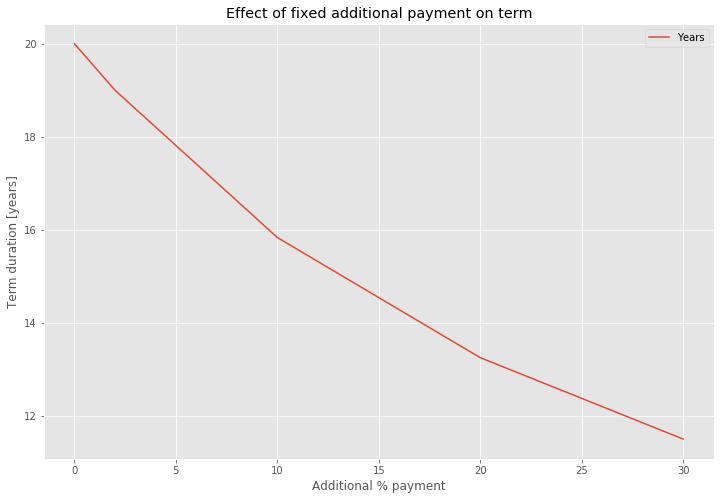

In [26]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='Years', ax=ax)
plt.title("Effect of fixed additional payment on term");
plt.ylabel("Term duration [years]");


The next graph shows the total money repaid on the contract as a function of additional payment.  

If no additional payment is made, the total amount paid back over the full term of the contract is 2.16 times the initial loan principal amount.

Notice how the interest dramatically reduces if a fixed additional payment is made. 
If you pay 30% extra over and above the required payment, the total amount paid back over the full term of the contract is 1.6 times the initial loan principal amount.

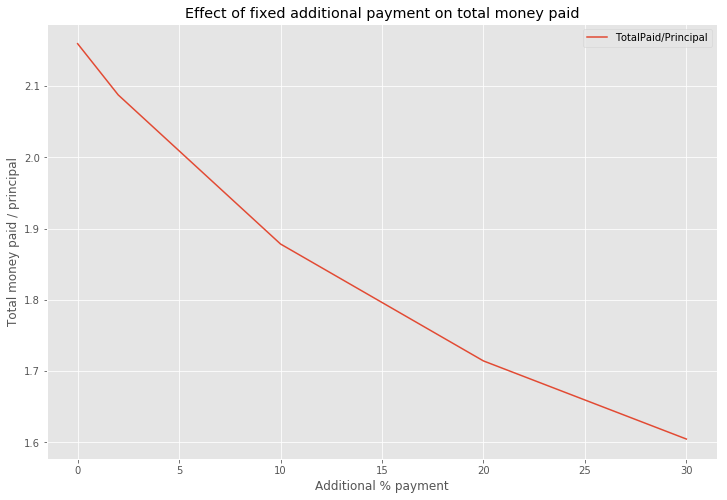

In [27]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
dfstats.plot(x='Additional % payment', y='TotalPaid/Principal', ax=ax)
plt.title("Effect of fixed additional payment on total money paid");
plt.ylabel("Total money paid / principal");


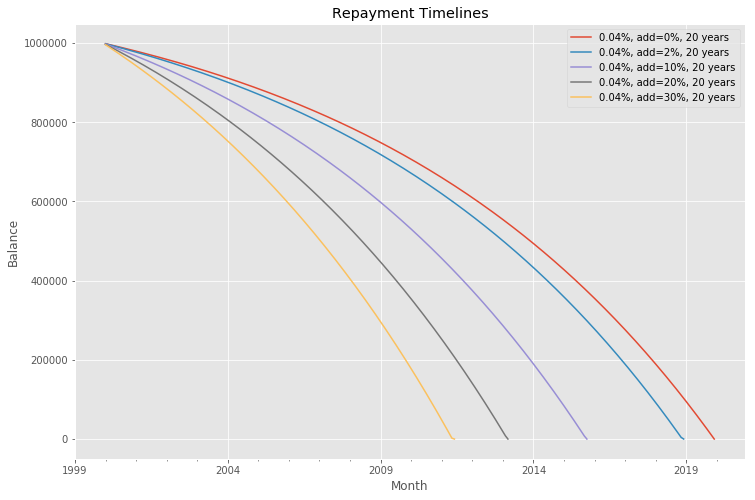

In [28]:
plot_balance(scenarios)

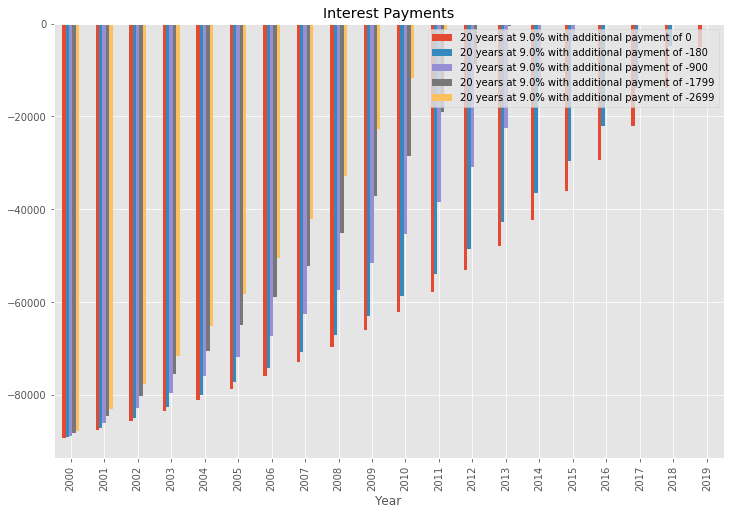

In [29]:
plot_annual_interest(schedules, stats)   

## Rental Property Analysis

Study the cash flow over some extended period `calcyears` when buying a property against a bonded loan for the purpose of renting it out. The loan can be fully repaid in `bondyears`, before the end of the extended study period. Hence in the initial `bondyears` the loan requires interest payment (as a cost against the property) and after the `bondyears` period, the interest is zero, with the property returning a positive inflow of cash.  The intent is to determine the effect of bond duration on the total cash flow over the extended period.

Given the loan amount, interest rate and other parameters, an additional payment is required to repay the loan at the end of the `bondyears` period. Hence, in the initial years the investment is cash flow negative as the loan is repaid.  The investment should become cash flow positive after the loan in repaid.  The question remains: over the extended analysis period, **what was the net cumulative cash flow?**  The smaller (or more negative) the net cumulative cash flow is, the poorer investment is.

For simplicity we assume that the additional loan down payment funds are free (no costs or losses in removing the funds from other investments).
We also assume that the tax is payable every month, whereas in real life, the tax is only payable on predetermined dates (once or twice per year).
The model allows for annual increase in rental income, rates and taxes, renting agency fees and levies. The tax benefit is also applied.

The model assumes that the rental income is paid towards depleting the bond (not removed as personal income).

The costs include: 
1. bond interest, cost of the loan, expressed as a percentage on outstanding balance.
1. maintenance, fix and maintain the property, expressed as percentage of rental income. Reasonable values should be 2% to 10% depending on the condition of the property. 
If it is a full-title property there should be no levies, but this maintenance cost should be higher.
If it is a sectional-title property there should be higher levies, but this maintenance cost should be lower, because much of the maintenance is already included in the levy.
1. renting agents fee (if applicable), expressed as percentage of rental income. It is convenient to use an agency to find renters and manage the rent agreement. Normally this is 7% to 10% of the rent.
1. levies (if applicable), if the property is part of a sectional title scheme.  This can also be used to include any costs to maintain buildings, gardens, etc.
1. Local government statutory rates and taxes.
1. risk of less than 100% occupancy, defaulting rent payments, damage to property, other other expenses arising from poor tenant behaviour.

**Note** the time value of money is not accounted for here, hence the situation is actually worse than what this analysis shows: we use expensive money to repay the loan early and earn cheap money positive cash flow later.

**Note** this analysis only considers the rental income and costs against this income.  The **capital growth is not considered at all in the present analysis**, it will be added later.

The calculation is as follows:

![](images/bond-optimisation.png)


In [30]:
# to calcuate the cash flow for a rental property

def rentalProperty(principal,interest_rate,bondyears,calcyears,rentpmonth,rentpermonthInc,agentPcnt,levy,
                   ratesnt,levyInc,ratesntInc,maintPcnt,
                   taxrate,riskPcnt=0,numAnnPayments=12,doplot=False,start_date=date(2000, 1,1)):
    
    reqpayment = round(np.pmt(rate=interest_rate/numAnnPayments, nper=bondyears*numAnnPayments, 
                              pv=principal, fv=0, when='end'),2)
   
    
    df, stats = amortisation_table(
        principal=principal, 
        interest_rate=interest_rate, 
        bondyears=bondyears, 
        reqpayment = reqpayment,
        numAnnPayments=numAnnPayments,
        start_date=start_date
        )
    numcycles = stats['Num Payments']
    
    # if loan is paid off before end of the term add zero-content lines
    if numcycles < calcyears * numAnnPayments + 1:
        if numcycles == 0:
            df = pd.DataFrame()
            curdate = start_date
        else:
            curdate = stats['Payoff Date']
        while numcycles < calcyears * numAnnPayments + 1:
            # add additional lines with zero interest costs 
            dic =  OrderedDict([('Month',curdate),
                           ('Period', numcycles+1),
                           ('Begin Balance', 0),
                           ('ReqPayment', 0),
                           ('Principal', stats['Principal']),
                           ('InterestRate', df['InterestRate'].mean()),
                           ('Interest', 0),
                           ('AddPayment', 0),
                           ('End Balance', 0)])
            df = df.append(pd.DataFrame(dic, index=[numcycles]),sort=True)
            curdate += relativedelta(months=1)
            numcycles += 1

    # rent income
    rischedule = annIncreaseTable(value=rentpmonth, increasepyear=rentpermonthInc, numcycles=numcycles)
    # costs
    levyschedule = annIncreaseTable(value=levy, increasepyear=levyInc, numcycles=numcycles,colhead='Levy')
    ratesntschedule = annIncreaseTable(value=ratesnt, increasepyear=ratesntInc, numcycles=numcycles,colhead='RatesT')


    # Now merge the bond table with the rent income table
    dfc = df.copy().drop(["AddPayment"],axis=1)
    dfc = dfc.merge(rischedule.drop(["Month"],axis=1), on='Period')
    dfc = dfc.merge(levyschedule.drop(["Month"],axis=1), on='Period')
    dfc = dfc.merge(ratesntschedule.drop(["Month"],axis=1), on='Period')

    #agent fees
    dfc['Agent'] = -agentPcnt * dfc['Rent']
    
    #maintenance
    dfc['Maint'] = -maintPcnt * dfc['Rent']

    #risk
    dfc['Risk'] = -riskPcnt * dfc['Rent']
    
    # number of payments
    dfc['NumPay'] = stats['Num Payments']

    # save tax for later
    dfc['TaxRate'] = taxrate
    
    #costs
    dfc['Costs'] = dfc['Interest']+ dfc['Agent']+ dfc['Levy']+ dfc['RatesT'] + dfc['Maint'] + dfc['Risk']
    
    # rent after cost before tax
    dfc['RentAfterCosts'] = dfc['Rent'] +   dfc['Costs']
    
    # tax and net income if bond present; can't get tax back on losses
    dfc['Tax'] = - taxrate * (dfc['RentAfterCosts'] )
    dfc['Tax'][dfc['Tax'] > 0] = 0
    
    dfc['Costs+Tax'] = dfc['Tax'] + dfc['Costs']
    dfc['Income'] = dfc['Rent'] + dfc['Costs+Tax'] 
    dfc['CashFlow'] = dfc['ReqPayment'] + dfc['Income']

    dfc['RentAfterCostsFrac'] = dfc['RentAfterCosts'] / dfc['Rent']
   
    
    #Create a summary statistics table
    istats = pd.Series([stats['Principal'],stats['Interest Rate'],stats['BondYears'],
                        stats['ReqPayment'],stats['Total Interest'],
                        dfc['CashFlow'].sum(),dfc["Period"].count(),
                        calcyears,
                         rentpmonth,  rentpermonthInc,
                         levy,  levyInc,
                         ratesnt,  ratesntInc,
                         taxrate,agentPcnt,
                         dfc['Maint'].sum(),maintPcnt,
                         dfc['Risk'].sum(),riskPcnt,
                         dfc["Rent"].sum(),
                         dfc["Tax"].sum(),
                         dfc["Income"].sum(),
                         dfc['RentAfterCosts'].sum() / dfc['Rent'].sum(),
                        ],
                       index=["Bond","Interest Rate","BondYears",
                              "ReqPaymentMonth","TotalInterest",
                              "CumCashFlow","Num Payments",
                              "CalcYears",
                              "InitRent",  "RentIncrease",
                              "InitLevy",  "LevyIncrease",
                              "InitR&T",  "R&TIncrease",
                              "TaxRate","AgentPcnt",
                              "Maint","MaintPcnt",
                              "Risk","RiskPcnt",
                              "Total Rent",
                              "Tax",
                              "Income",
                              "RentAfterCostsB4TaxFrac",
                             ])


    if doplot:
        plotrentalpropcashflowtimeline(dfc)        
        plotrentalpropeffectiverent(dfc)        

#     display(HTML(dfc.head().to_html()))
#     display(HTML(dfc.tail().to_html()))
#     stats
    return dfc,istats


In [31]:
def plotrentalpropcashflowtimeline(dfc):
    import matplotlib.pyplot as plt
    figsize(12,8)
    fig, axes = plt.subplots(nrows=1, ncols=1)

    dfc.plot(x='Month',y='Rent', label='Gross rent income', ax=axes)    
    dfc.plot(x='Month',y='RentAfterCosts', label='Net rent income after costs before tax', ax=axes)    
    dfc.plot(x='Month',y='Interest', label=f'Interest={interest_rate}', ax=axes)    
    dfc.plot(x='Month',y='Costs+Tax', label='Costs+Tax', ax=axes)  
    dfc.plot(x='Month',y='CashFlow', label='Cash flow', ax=axes)    
    dfc.plot(x='Month',y='Tax', label=f'Tax={taxrate}', ax=axes)    
    plt.title("Rental property cash flow timelines");
    plt.ylabel("Value");
    plt.xlabel("Time");


def plotrentalpropeffectiverent(dfc):
    import matplotlib.pyplot as plt
    
    meanval = dfc['RentAfterCosts'].sum() / dfc['Rent'].sum()
    figsize(12,8)
    fig, axes = plt.subplots(nrows=1, ncols=1)
    dfc.plot(x='Month',y='RentAfterCostsFrac', label='Rent-after-costs-before-tax / Rent', ax=axes,ylim=[0,1])    
    plt.title(f"Effective rent after cost before tax, mean value={meanval:.3f}");
    plt.ylabel("Fraction");
    plt.xlabel("Time");    

**Note** The parameters used in the following investigation are not optimal in the sense that the rent income is poor relative to the cost of the property.
It may be possible to get half of this rent income (3000) for some properties costing a quarter of the value considered here (250k).



The parameters used in the analysis are as follows:

In [32]:
principal = 1000000
interest_rate = 0.097
bondyears = 5
calcyears = 20
rentpmonth = 7000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnt = 0.01
levy = -600
ratesnt = -600
levyInc = 0.06
ratesntInc = 0.06
taxrate = 0.33

dfc,istats = rentalProperty(principal=principal,interest_rate=interest_rate,
                bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

In [33]:
display(HTML(istats.to_frame().to_html(index=True)))

,0
Bond,1.00000e+06
Interest Rate,9.70000e-02
BondYears,5.00000e+00
ReqPaymentMonth,-2.10997e+04
TotalInterest,-2.65984e+05
CumCashFlow,2.00327e+04
Num Payments,2.41000e+02
CalcYears,2.00000e+01
InitRent,7.00000e+03
RentIncrease,6.00000e-02


### Monthly cash flow

The cash flow time line shows that  high costs (agent fees, maintenance, levies, rates & taxes) destroy the investment potential of property.  For effective investment return, you must bring down the costs dramatically.

The net monthly cash flow is negative while the bond is repaid, but positive afterwards.

Initially, the net rent after cost (including interest, but excluding payments against the principal) is negative, because the loan interest is very high. 



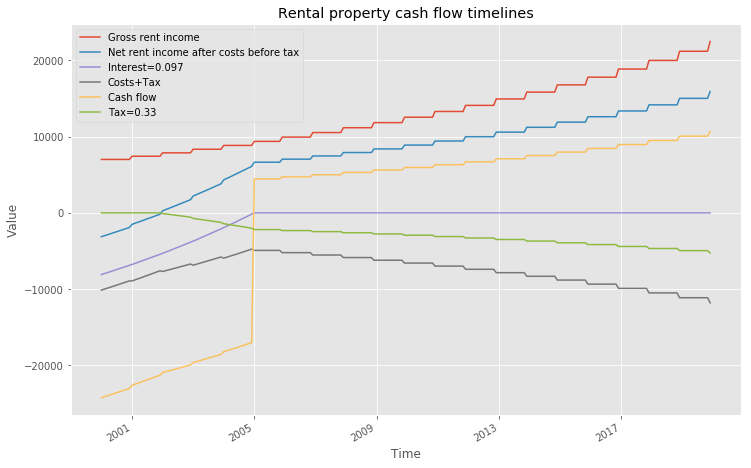

In [34]:
plotrentalpropcashflowtimeline(dfc)

Define the effective rent income as the fraction of the net rent income (after costs) to the gross rent income. With zero cost the effective rent income should be 1. Any costs will reduce this income to smaller than 1. We answer the question:  after costs, what is the net inflow from the investment?

In this graph, costs are defined as all outflows against the rental property, including bonded loan interest, agent's fees, levies, rates and taxes and maintenance.
This value does not include income tax in the hands of the investor or the down payment against the loan capital or principal. 

In the graph below the loan is repaid after five years and the interest is zero.

The graph title shows the mean value over the extended period of study. This value include the initial negative cash flow (interest), but excludes income tax and loan capital repayment.


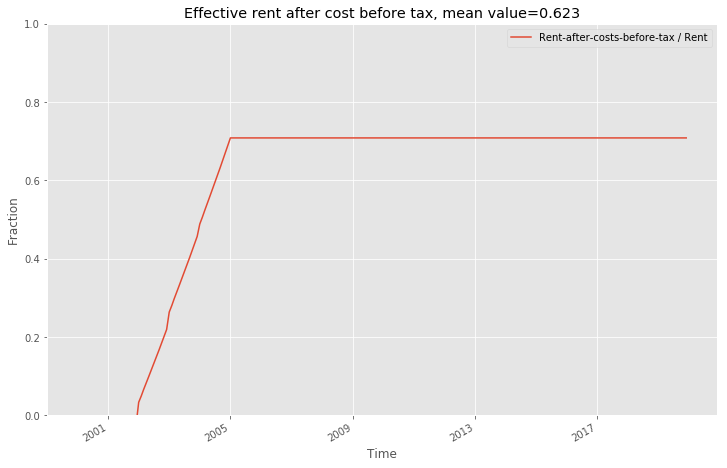

In [35]:
plotrentalpropeffectiverent(dfc)    

### Effect of income tax and  bonded loan duration 

Next investigate the effect of mortgage bond duration and tax rate on net cumulative cash flow over an extended period.
If you buy a property, which mortgage bond duration will give the best net cash flow over an extended period?   
How much does the cash flow differ for different bond  durations?  

The model considers the cumulative cash flow over a 20-year duration, of which the bond duration is the first $n$ years.  The principal amount, interest rate, the rent and all other costs are the same in all cases, only the bond payment duration varies.

In [36]:
principal = 1000000
interest_rate = 0.097
calcyears = 20
rentpmonth = 7000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnt = 0.01
levy = -600
ratesnt = -600
levyInc = 0.06
ratesntInc = 0.06

dfSum = pd.DataFrame()

for bondyears in [3, 4,5,7,10,20]:
    for taxrate in [0.2, 0.33, 0.42]:
        dfc,istats = rentalProperty(principal=principal,interest_rate=interest_rate,
                bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

        # append all summaries into single df
        dfSum = dfSum.append(istats,ignore_index=True)



The table below shows the scenario parameters for the results shown further down below:

In [37]:
istatsfiltex = istats[['Bond','Interest Rate','CalcYears','InitRent','RentIncrease','InitLevy',
                    'LevyIncrease','InitR&T','R&TIncrease','AgentPcnt','MaintPcnt','RiskPcnt']]
display(HTML(istatsfiltex.to_frame().to_html(index=True)))

,0
Bond,1000000.000
Interest Rate,0.097
CalcYears,20.000
InitRent,7000.000
RentIncrease,0.060
InitLevy,-600.000
LevyIncrease,0.060
InitR&T,-600.000
R&TIncrease,0.060
AgentPcnt,0.080


###  Net cumulative cash flow

The table shows the net cumulative cash flow (sum of cash flow over the extended period `CalcYears` od 20 years) as a function of bond pay-back period and tax rate.

It is clear that a 42% tax rate requires that the bond be paid off in three years in order to achieve a  positive net cumulative cash flow *only after 20 years*.
In this case the investment has only paid back the loan money but has not yet given any other income.

At a 20% tax rate the investment provides positive net cumulative cash flow after 20 years for a bond paid off in less than seven years.
At this tax rate, if you repaid the bond in four years, the investment will return about 400k net cash flow after 20 years.

At a 33% tax rate the investment provides positive net cumulative cash flow after 20 years for a bond paid off in less than four years.

Tax and *all* of the other 'cost' items contribute to this performance: the conclusion is that all costs must be minimised to make the investment worthwhile in terms of net cumulative cash flow after 20 years.


In [38]:
dft = pd.pivot_table(dfSum, index=['BondYears'],values=['CumCashFlow'],columns=['TaxRate'])
display(HTML(dft.to_html(index=True)))


### Effective rent after cost before tax

The following table shows the net rent income after costs (including interest) before income tax (also excluding the repayment of the loan capital).

It is evident for the property considered here, the longer term loan durations spends most of the rental income to repay the bond.

The data in the table is shown further down in graph format, when comparing with alternative investment options.

In [39]:
dfer = pd.pivot_table(dfSum, index=['BondYears'],values=['RentAfterCostsB4TaxFrac'],columns=['TaxRate'])
display(HTML(dfer.to_html(index=True)))

### Alternative, lower cost investment analysis

Consider less expensive property with lower rental income, but where the rent is relatively higher compared to the price of the property.

Consider a property at a quarter of the purchase cost of the property considered above, but where the property raises 3000 rental income.
In order to keep the same loan amount, four properties are bought and considered as a collective in this analysis.

The risk of damages in cheaper properties is higher than for the more expensive investment.  
How much higher must the risk be for similar returns as on the expensive property?
We consider a reasonable risk value 10% of rent, and the threshold value (26% for these scenarios) where the more expensive property is the better investment.


In [40]:
principal = 4 * 250000
interest_rate = 0.097
calcyears = 20
rentpmonth = 4 * 3000
rentpermonthInc = 0.06
agentPcnt = 0.08
maintPcnt = 0.03
riskPcnts = [0.1, 0.26]
levy = -4 * 400
ratesnt = -4 * 250
levyInc = 0.06
ratesntInc = 0.06

dfSum2 = pd.DataFrame()

for riskPcnt in riskPcnts:
    for bondyears in [3, 4,5,7,10,20]:
        for taxrate in [0.2, 0.33, 0.42]:
            dfc,istats = rentalProperty(principal=principal,interest_rate=interest_rate,
                    bondyears=bondyears,calcyears=calcyears,rentpmonth=rentpmonth,rentpermonthInc=rentpermonthInc,
                    agentPcnt=agentPcnt,levy=levy,ratesnt=ratesnt,levyInc=levyInc,
                    ratesntInc=ratesntInc,maintPcnt=maintPcnt,taxrate=taxrate,riskPcnt=riskPcnt,doplot=False)

            # append all summaries into single df
            dfSum2 = dfSum2.append(istats,ignore_index=True)


In [41]:
istatsfilt = istats[['Bond','Interest Rate','CalcYears','InitRent','RentIncrease','InitLevy',
                    'LevyIncrease','InitR&T','R&TIncrease','AgentPcnt','MaintPcnt']]
display(HTML(istatsfilt.to_frame().to_html(index=True)))

,0
Bond,1000000.000
Interest Rate,0.097
CalcYears,20.000
InitRent,12000.000
RentIncrease,0.060
InitLevy,-1600.000
LevyIncrease,0.060
InitR&T,-1000.000
R&TIncrease,0.060
AgentPcnt,0.080


In [42]:
dftc = {}
for i,riskPcnt in enumerate(riskPcnts):
    dftc[i] = pd.pivot_table(dfSum2.loc[dfSum2['RiskPcnt']==riskPcnts[i]], 
                             index=['BondYears'],values=['CumCashFlow'],columns=['TaxRate'])
#     display(HTML(dftc[i].to_html(index=True)))


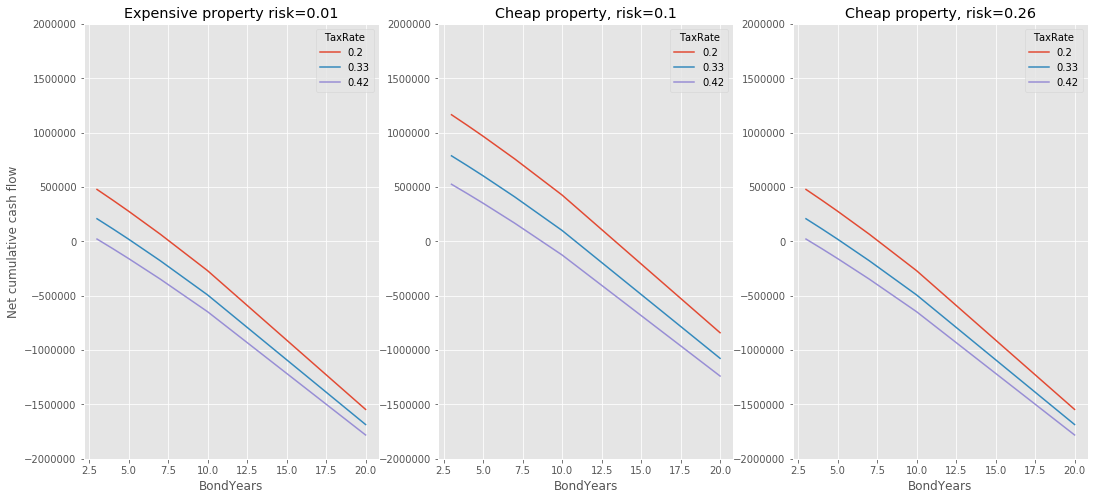

In [43]:
import matplotlib.pyplot as plt
figsize(18,8)
fig, axes = plt.subplots(nrows=1, ncols=3)
dft.reset_index().plot(x='BondYears',y='CumCashFlow',  ax=axes[0],ylim=[-2e6,2e6])    
axes[0].set_ylabel("Net cumulative cash flow");
axes[0].set_title(f"Expensive property risk={istatsfiltex['RiskPcnt']}");

for i,riskPcnt in enumerate(riskPcnts):
    dftc[i].reset_index().plot(x='BondYears',y='CumCashFlow',  ax=axes[i+1],ylim=[-2e6,2e6])      
    axes[i+1].set_title(f"Cheap property, risk={riskPcnt}");

The above analysis shows that for the scenarios considered, if the risk is higher than 26% of rent, the more expensive property is the better investment.
This is however, quite a high risk, it should be lower in a well managed portfolio.

The graphs show that at 10% risk, the less expensive property performs somewhat more than twice as good as the more expensive property.

In conclusion, if you are able and willing to manage the risks down low, the less expensive properties are considerable better investments than the more expensive property.
If the risks are higher or you don't want the trouble of managing risk and trouble the more expensive property still remains an option (less attractive though), especially if you do not operate the properties as a large scale business.

Finally, it seems that unless you tightly manage the costs and risks the cost of a rental investment, in terms of rental income only (ignoring capital growth) is of the same order as the costs of managed investments such as unit trusts (managed investments). If the management fee of a  unit trust is around 2% of fund value, the investor loses about 40% of the potential growth of the investment (details to follow).


Keep in mind that capital growth is not yet factored into this analysis.

# All items below this are only sketchy notes at present, to be completed later!

## Moving funds between bonds for minimal interest

### The scenario

Suppose I need to raise some money to buy a property but a mortgage bond is not optimal because the money must be paid back in a short time.  It was shown above that for shorter-term loans, the cost of obtaining the bond minimises the tax savings benefit.

There are three existing mortgage bonds against which money can be drawn against. Two of these properties raise rent income, hence the interest can be claimed against tax.  The third property mortgage has the lowest interest rate but the interest cannot be claimed against tax. The final objective is to repay all three mortgage bonds in four to five years. How much money must be drawn from the three different mortgage bonds to raise the new money for the lowest total cost? To repay all three bonds in the required time, how much additional payment must be made in each mortgage bond?

This is a classical minimisation problem, which can be solved by many different techniques.

To be completed

## The True Cost of Unit Trust Funds

Still to be completed

From 
https://www.coronation.com/personal/new-investor/about-unit-trusts/:
A unit trust (also known as a ‘fund’) pools money from many investors to invest in assets like shares, bonds and property. Instead of having to pick individual investments yourself, a unit trust offers you exposure to a range of assets, which are selected and managed by investment professionals. Each fund is divided into equal units. The price of each of these units is based on the value of all the investments in the fund. As an investor, you own a number of units in a fund. Over time, the price of these units will track the value of the underlying investments. 
Coronation does not charge any initial or upfront fees to invest in our unit trust funds. Your full investment amount is invested to purchase units. Our unit trusts charge an annual management fee which is calculated daily. Certain funds may charge a performance fee which is accrued daily and paid monthly for all funds, except the Coronation Optimum Growth fund which is paid annually on 30 September. For more information, please view our Fee Schedule in the forms section on Coronation.co.za. 
The Coronation schedule lists fees of 0.85% to 1.25%, and in some funds even 3% (Domestic long term Top 20). Other fund managers have similar fees.

The fund manager takes this fee on a daily basis (compounded) irrespective of the performance of the investment. So if the investment is not growing, you lose money at these daily compounded rates. Also, it means that the investment show show better growth than these fees, before you earn investment income.   A very nice way to pay for the fund manager's new Porche!




## Retirement Fund Depletion

to be completed


DCF:  
https://www.investopedia.com/terms/d/dcf.asp  
https://www.wallstreetprep.com/knowledge/dcf-model-training-6-steps-building-dcf-model-excel/  
http://kaushik316-blog.logdown.com/posts/1651749-stock-valuation-with-python  
https://stackoverflow.com/questions/35849994/financial-modelling-with-pandas-dataframe  

